<font face="Calibri" size="2"> <i>SBAE - Notebook Series - Part 3, version 0.2,  September 2022. Andreas Vollrath, UN-Food and Agricultural Organization, Rome</i>
</font>

![title](images/header.png)

# III A - SBAE - spatially balanced subsampling
### Extract a subset of samples from K-Means clusters 
-------

This notebook takes you through the process of creating a sub-sample of the time-series and change data retrieved in II. The objective is to obtain a statisitically balanced subsample that can be used for training data collection, and ideally includes a higher precentage of rare classes such as de-forestation, degradation and gain when compared to a pure random subsampling approach. 

### Load libraries

In [1]:
# data management
import numpy as np
import pandas as pd
import geopandas as gpd

# clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# sbae internal functionality  
import helpers as h

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/lib/python3.8/dist-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### 1 Load geopackage results file

The first step is to load the results file from Notebook II of the SBAE notebook series. This file should contain the outputs from various time-series algorithms and may additionally hold extracts from 

In [2]:
df = gpd.read_file('erp_5km/results_Landsat_ndfi_1985-01-01_2000-01-01_2017-01-01.gpkg')

print('Available Columns')
df.columns

Available Columns


Index(['LON', 'LAT', 'PLOTID', 'aspect', 'dw_class_mode', 'dw_tree_prob__max',
       'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean',
       'elevation', 'esa_lc20', 'esri_lc20', 'gfc_gain', 'gfc_loss',
       'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'point_id',
       'potapov_tree_height', 'slope', 'tmf_2000', 'tmf_2001', 'tmf_2002',
       'tmf_2003', 'tmf_2004', 'tmf_2005', 'tmf_2006', 'tmf_2007', 'tmf_2008',
       'tmf_2009', 'tmf_2010', 'tmf_2011', 'tmf_2012', 'tmf_2013', 'tmf_2014',
       'tmf_2015', 'tmf_2016', 'tmf_2017', 'tmf_defyear', 'tmf_degyear',
       'tmf_main', 'tmf_sub', 'point_idx', 'images', 'ccdc_change_date',
       'ccdc_magnitude', 'ltr_magnitude', 'ltr_dur', 'ltr_yod', 'ltr_rate',
       'ltr_end_year', 'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', '

### 2 Select relevant columns for creating the clusters

Not all columns in the loaded data should go into the clustering process, e.g. the point_id does not tell us anything about the statistical distribution with regard to change. In the cell below is a pre-selection of columns that potentially contain information on change and therefore shall be helpful in creating meaningful clusters for later subsampling.


In [8]:
# select columsn thata re used by Kmeans
cols_to_cluster = [
    'mon_images',
    #'elevation',
    #'dw_class_mode', 'dw_tree_prob__max',
    #'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean',
    'bfast_magnitude', 'bfast_means', 
    #'lang_tree_height', 
    #'potapov_tree_height',
    'ccdc_magnitude',
    'ltr_magnitude', 'ltr_dur', 'ltr_rate', 
    'cusum_confidence', 'cusum_magnitude', 
    'ts_mean', 'ts_sd', 'ts_min', 'ts_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_min', 'bs_slope_max'
]

### 3 Check for NaNs

The clustering process does not accept NaNs in any of the fields. There are 2 strategies:

1. Remove all rows that contain any NaNs
2. Replace all NaNs with a number

In [9]:
print(' Length of original dataframe: ' + str(len(df)))
df_1 = df.copy()
print(' Length of nan-removed dataframe: ' + str(len(df_1[cols_to_cluster].dropna())))

for col in cols_to_cluster:
    print(f' Column {col} contains {len(df_1[df_1[col].isna()])} NaNs')
    # print(f' Column {col} contains {len(df_1[df_1[col].isin([np.inf, -np.inf])])} Infinites')

 Length of original dataframe: 1862
 Length of nan-removed dataframe: 1862
 Column mon_images contains 0 NaNs
 Column bfast_magnitude contains 0 NaNs
 Column bfast_means contains 0 NaNs
 Column ccdc_magnitude contains 0 NaNs
 Column ltr_magnitude contains 0 NaNs
 Column ltr_dur contains 0 NaNs
 Column ltr_rate contains 0 NaNs
 Column cusum_confidence contains 0 NaNs
 Column cusum_magnitude contains 0 NaNs
 Column ts_mean contains 0 NaNs
 Column ts_sd contains 0 NaNs
 Column ts_min contains 0 NaNs
 Column ts_max contains 0 NaNs
 Column bs_slope_mean contains 0 NaNs
 Column bs_slope_sd contains 0 NaNs
 Column bs_slope_min contains 0 NaNs
 Column bs_slope_max contains 0 NaNs


# 2 K-Means Clustering

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[147   1 500  36 323 419   2  18  43  60  65 248]


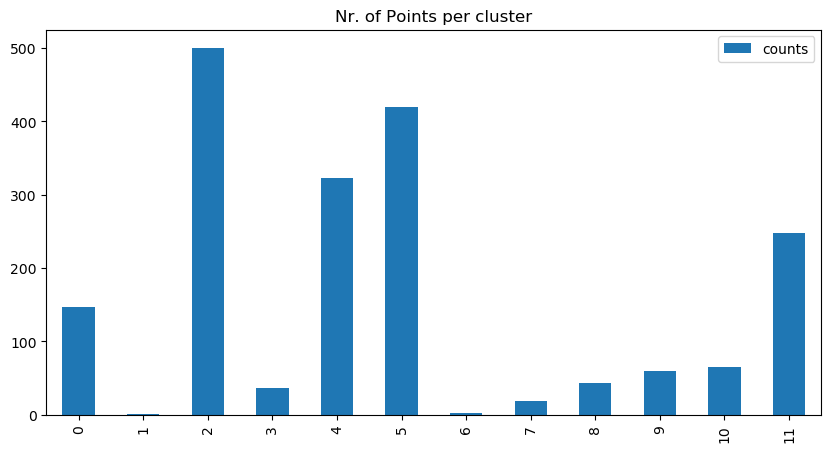

In [12]:
nr_of_cluster=12

# run kmeans
kmeans = KMeans(n_clusters=nr_of_cluster, random_state=42).fit(df[cols_to_cluster])

#------------------------------------------------
# Standardize the data
#X_std = StandardScaler().fit_transform(df[cols_to_cluster])
# run kmeans with standardized data
#kmeans = KMeans(n_clusters=nr_of_cluster, random_state=42).fit(X_std)
#------------------------------------------------

# add the cluster column
df['Kmeans'] = kmeans.predict(df[cols_to_cluster])

# print number of points per clusters
clusters, counts = np.unique(df.Kmeans, return_counts=True)
print(clusters)
print(counts)

# plot data
pd.DataFrame({'counts': counts}).plot(kind='bar', title='Nr. of Points per cluster', figsize=(10,5))

# 3 Plots

## 3.1 Plot Statistics of each cluster

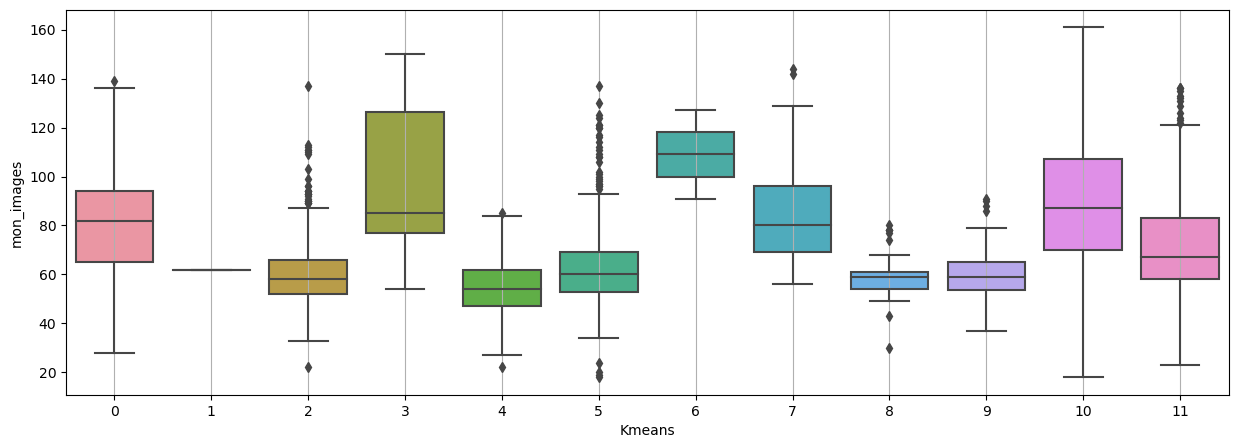

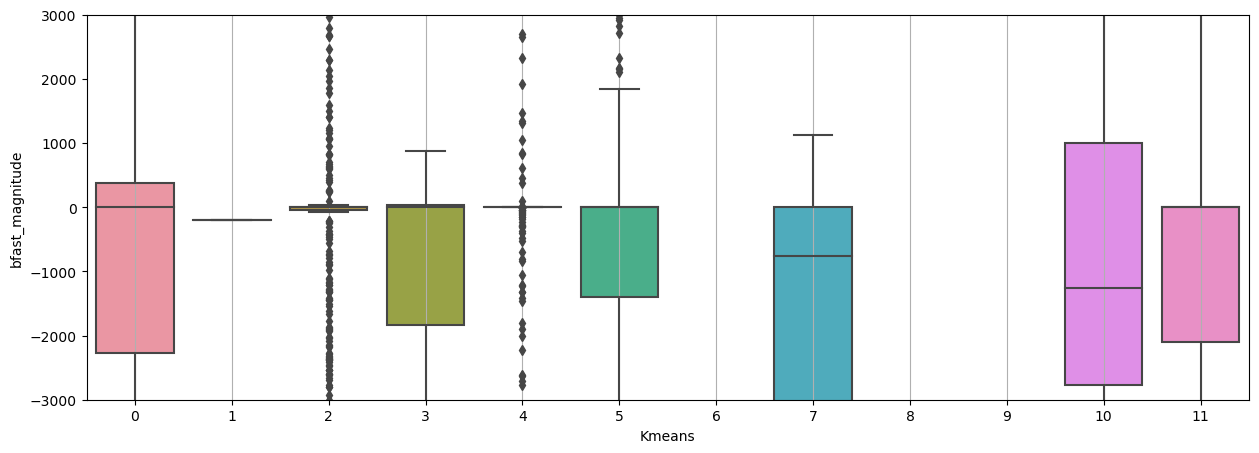

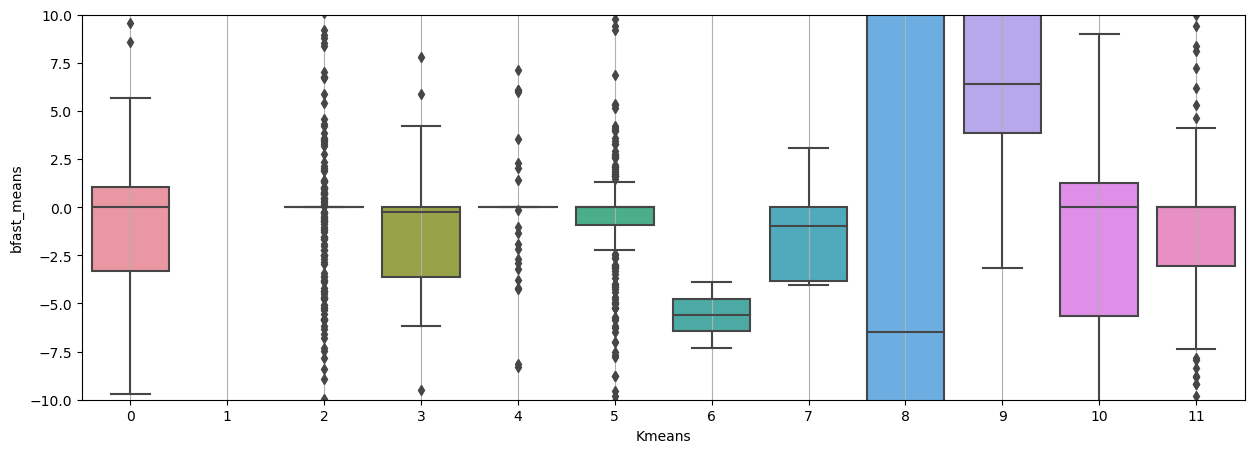

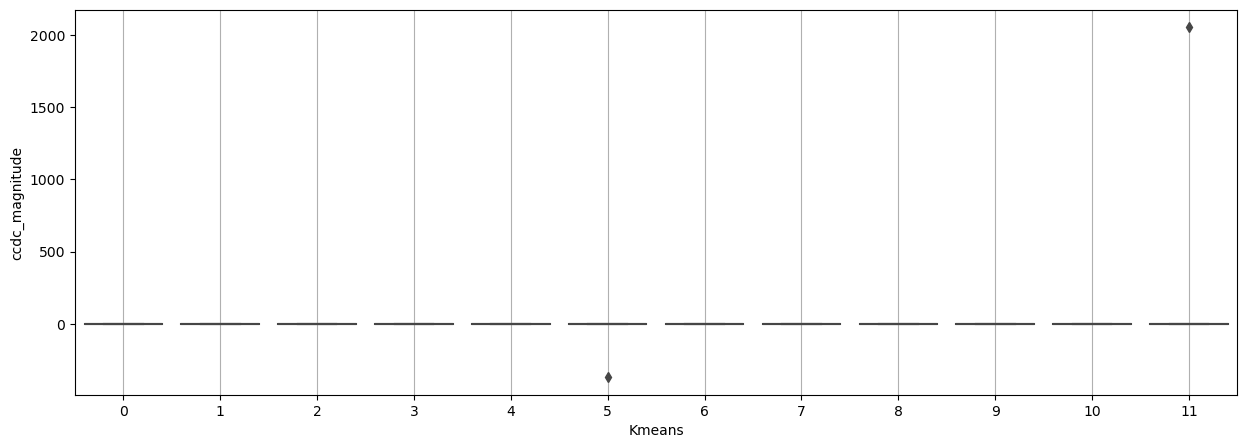

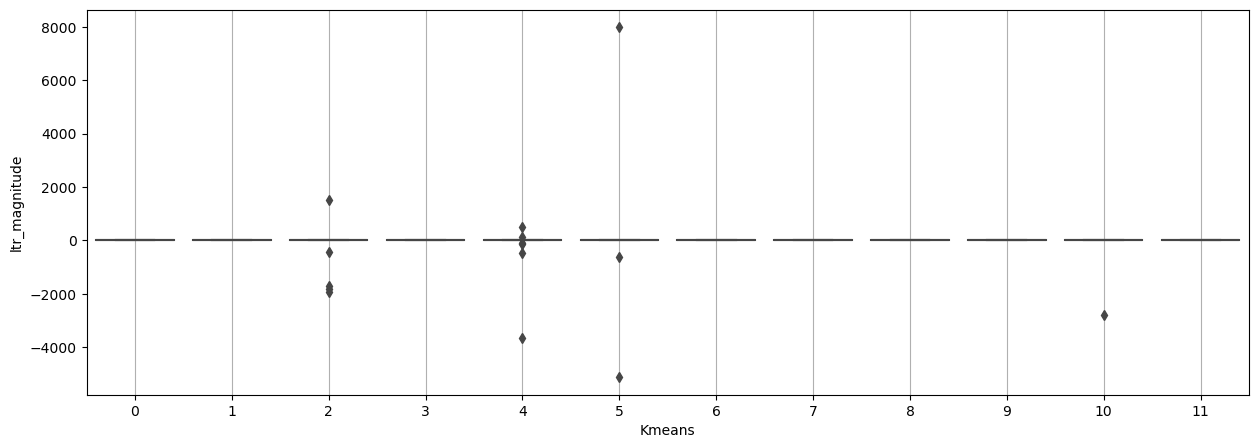

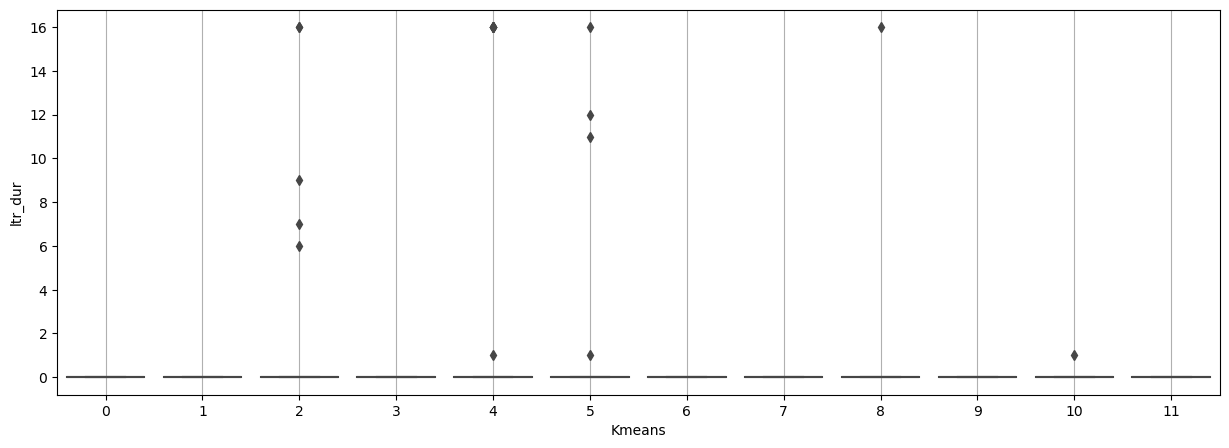

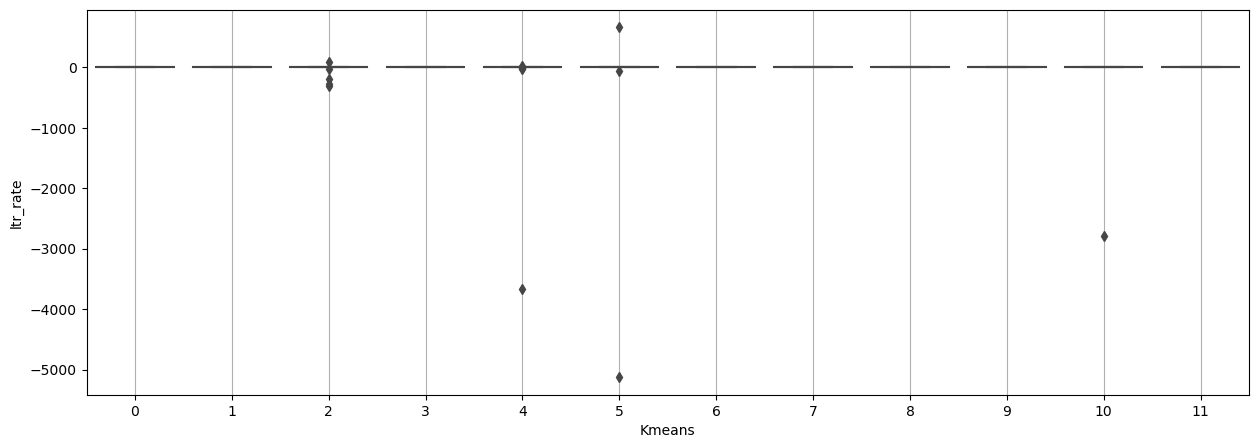

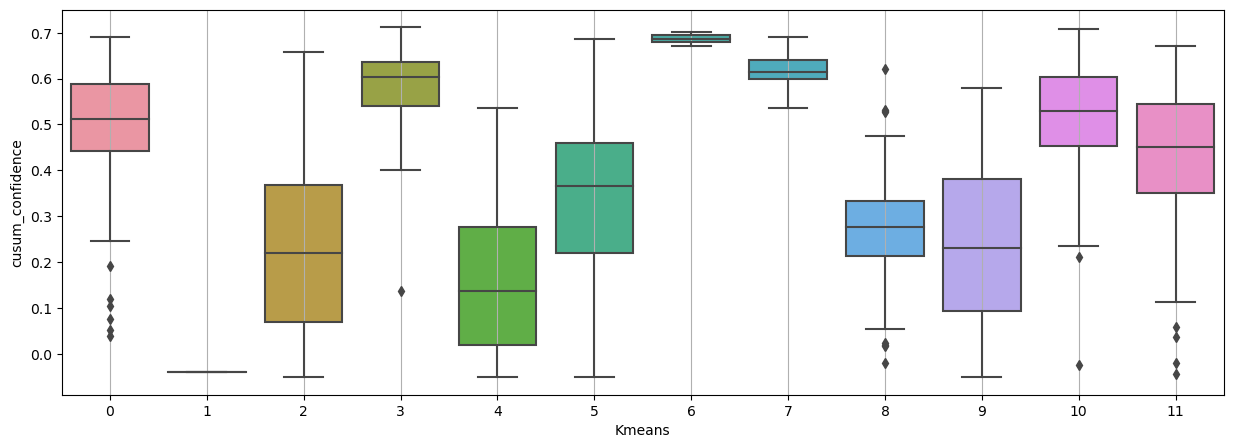

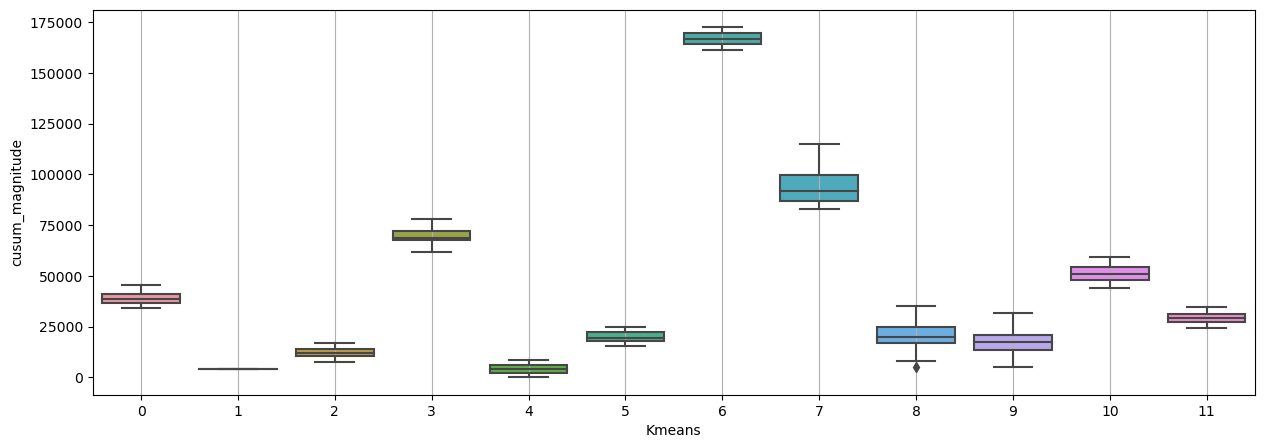

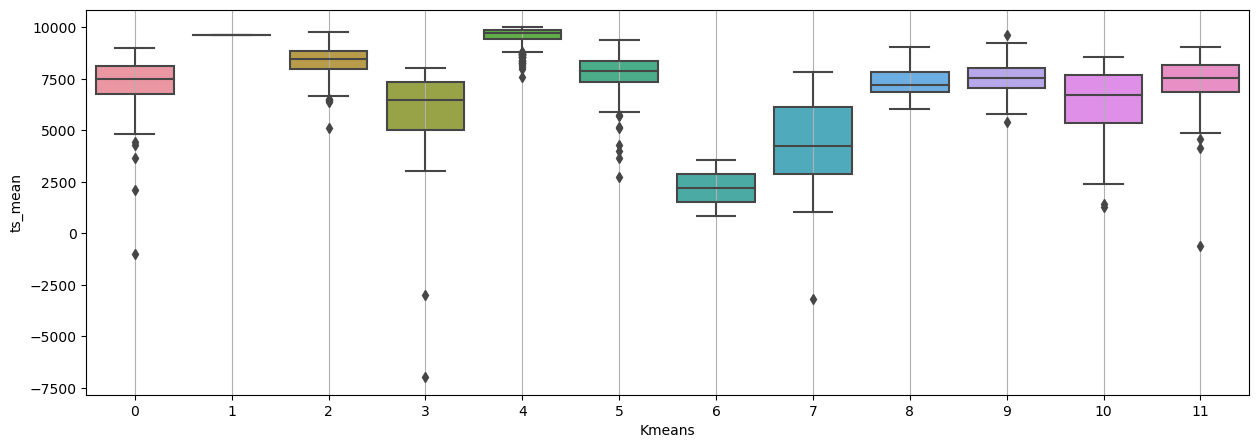

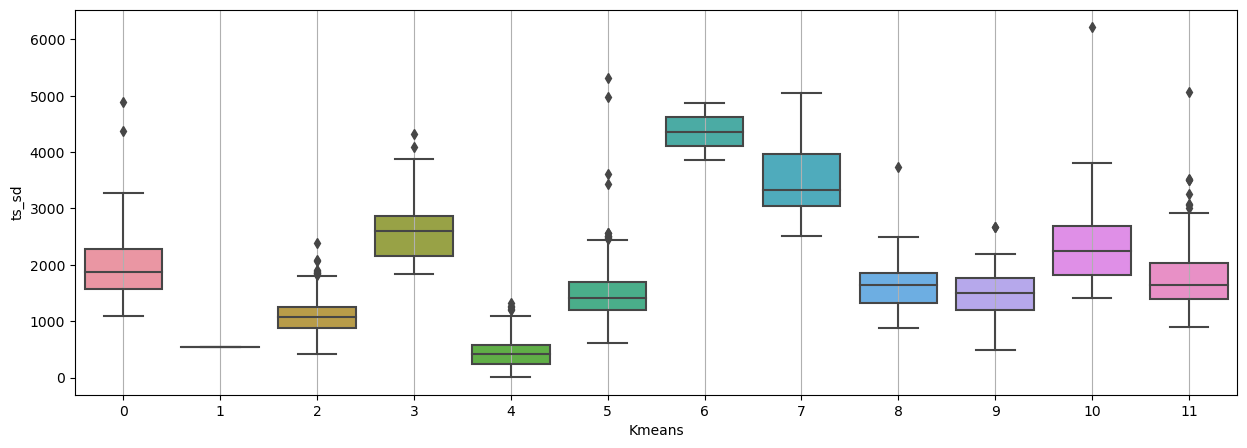

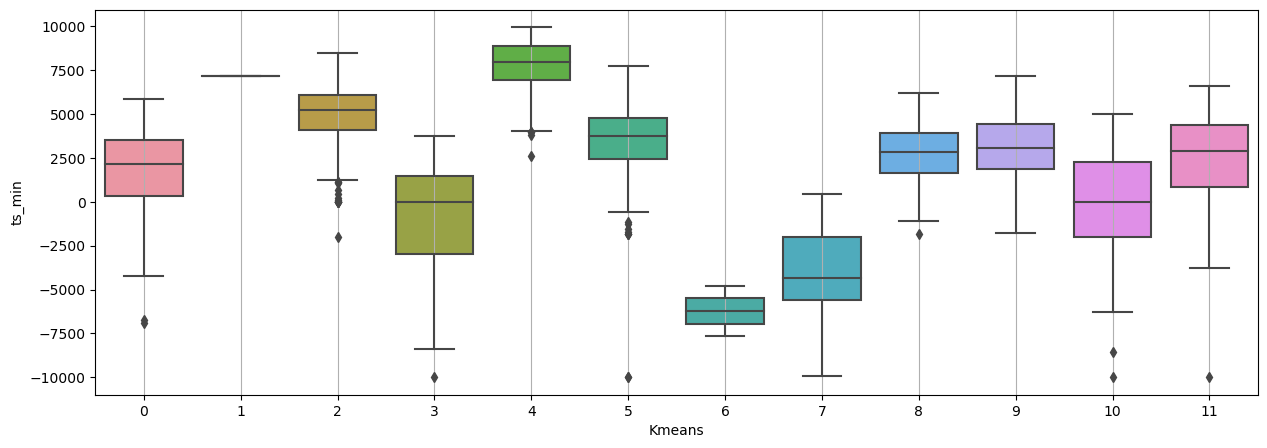

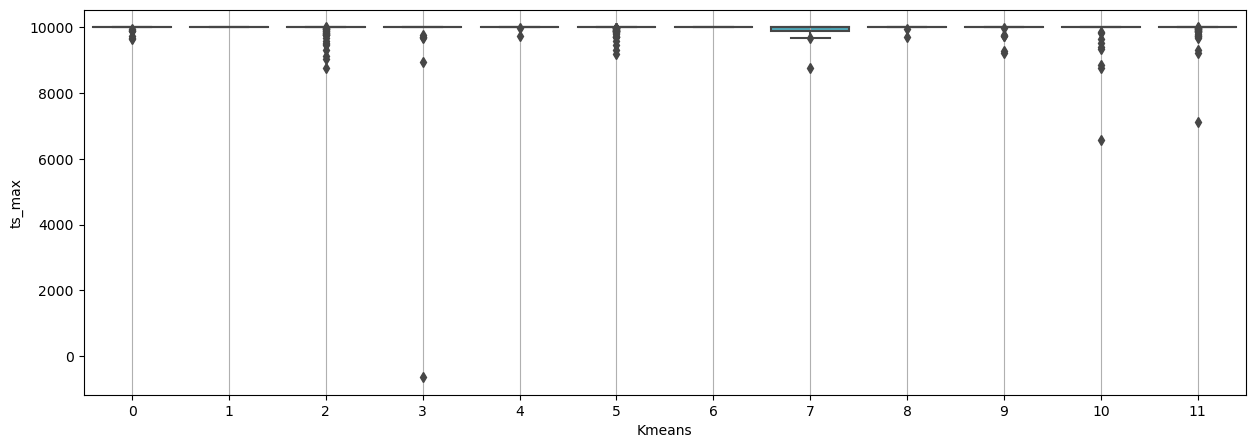

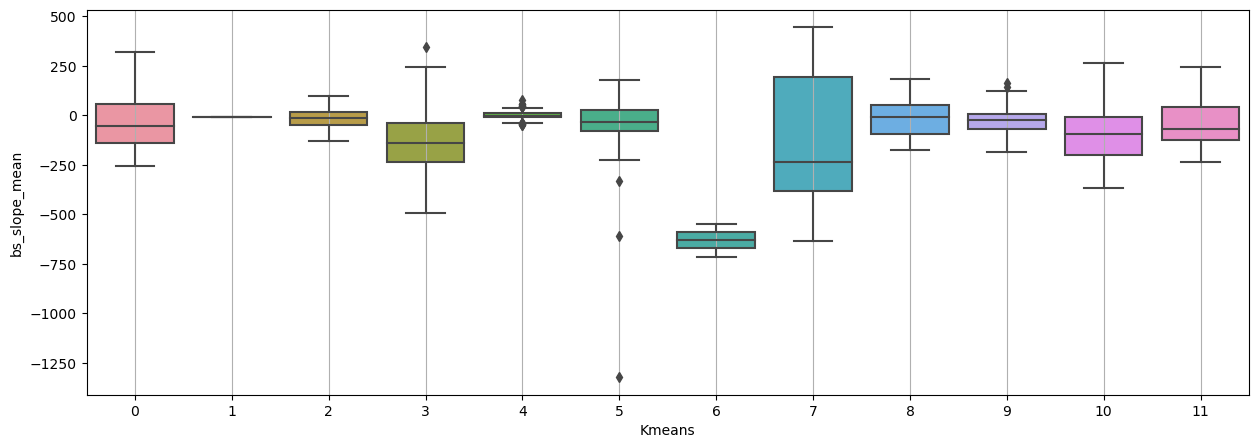

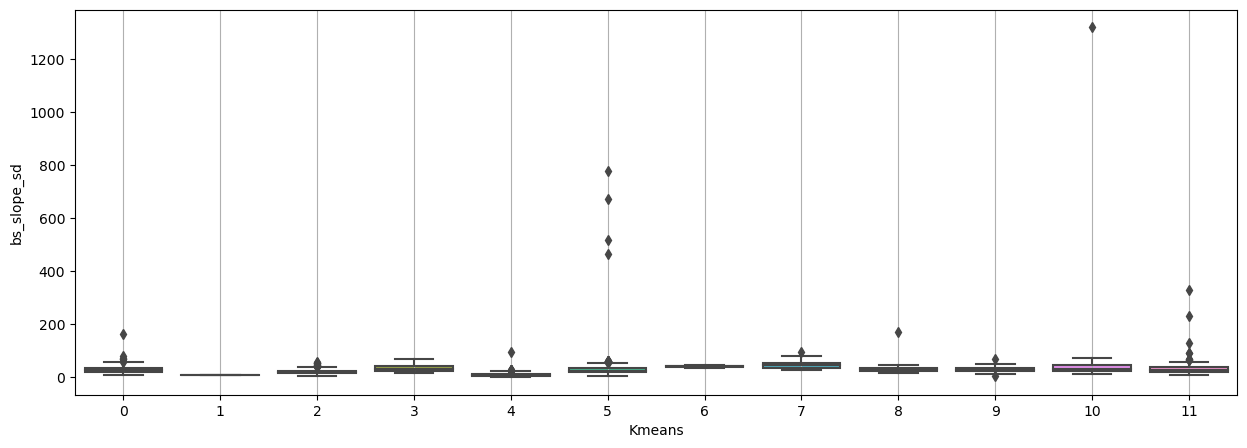

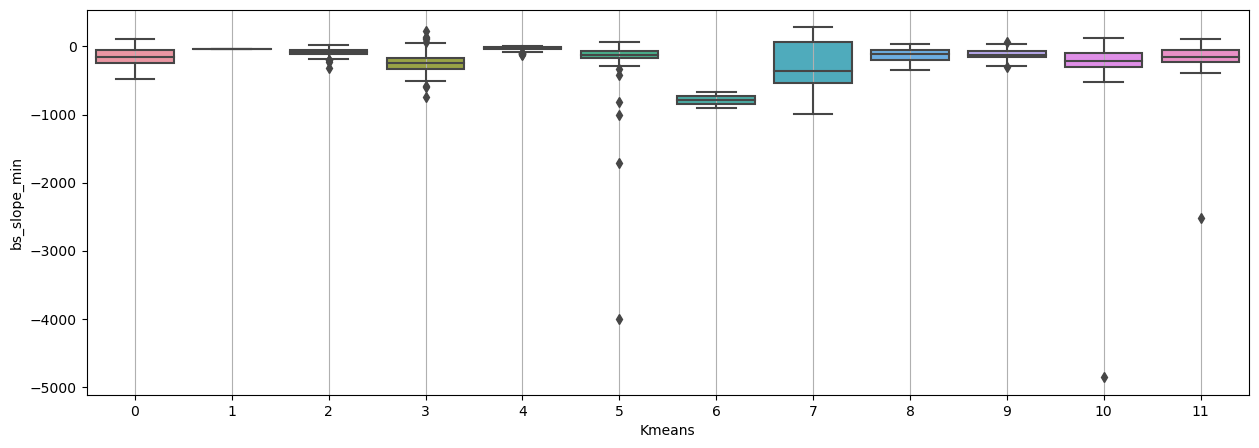

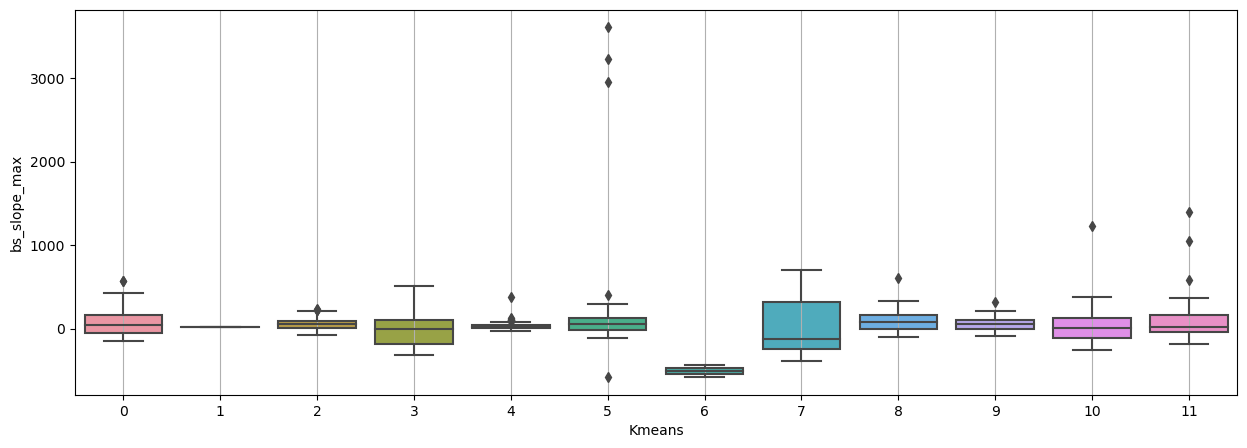

In [13]:
cols_to_plot = cols_to_cluster

# in case you want to have that different
#cols_to_plot = [
#    'mon_images',
#    'cusum_confidence', 'cusum_magnitude', 
#    'ts_mean', 'ts_sd', 'ts_min', 'ts_max', 
#    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_min', 'bs_slope_max'
#]


fig, axs = h.plot_stats_per_class(df, 'Kmeans', cols_to_plot)

#### Save a figure

In [15]:
from pathlib import Path

Path.cwd().joinpath('plots').mkdir(exist_ok=True)
# to save a figure of a certain column/attribute
col = 'mon_images' 

fig[col].savefig(f'plots/{col}.png')

## 3.2 Highlight specific cluster on a map

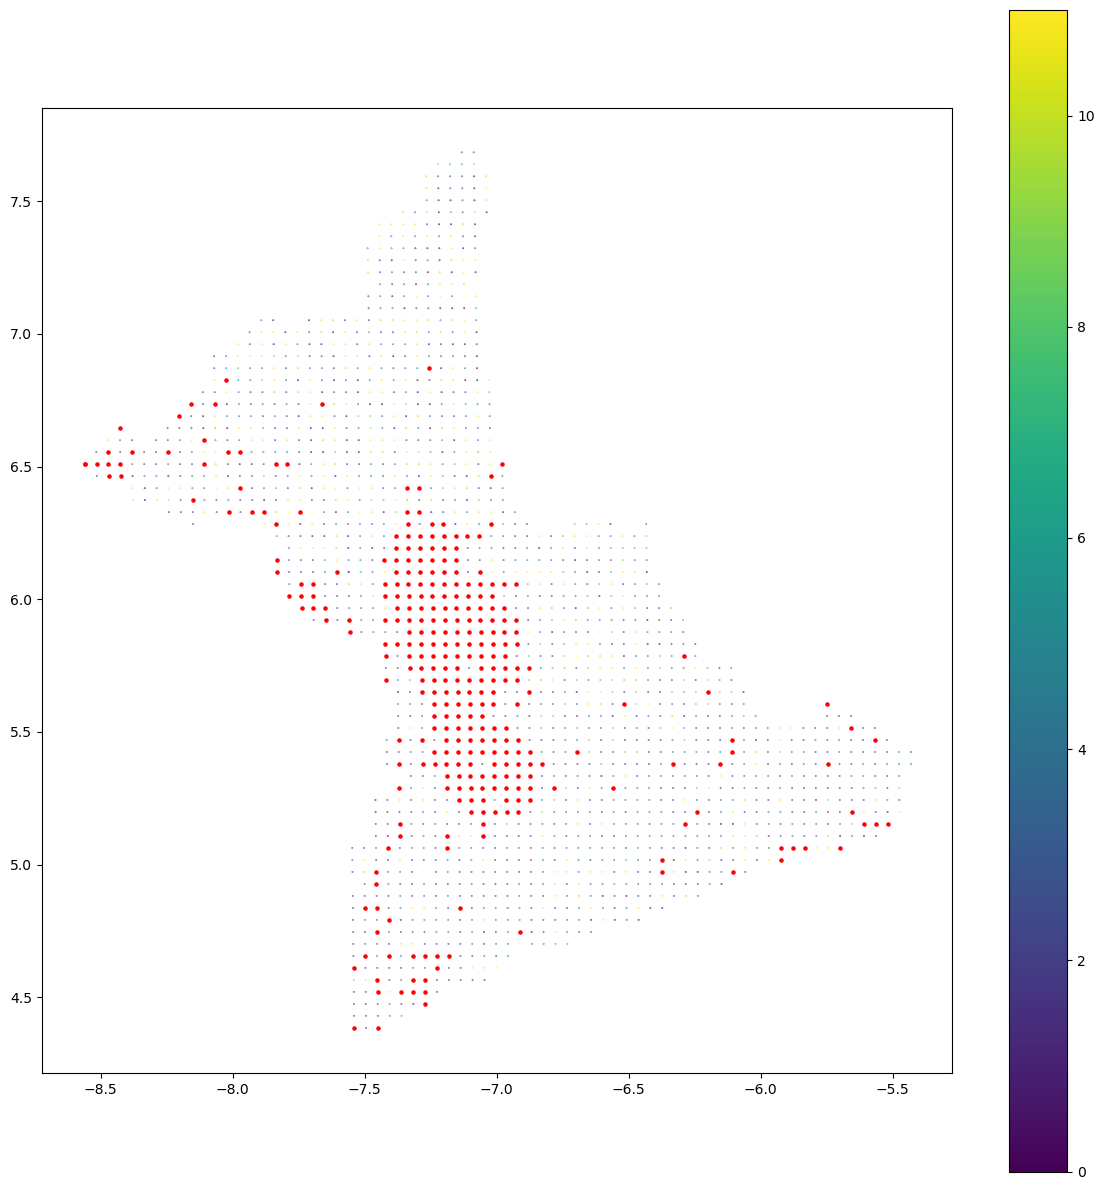

In [19]:
cluster_to_highlight = 4

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df.plot(ax=ax, column='Kmeans', legend=True, markersize=.1)
df[df['Kmeans']==cluster_to_highlight].plot(ax=ax, markersize=5, facecolor='red')
plt.tight_layout()

# 4 Select subset of samples for each cluster

246 samples have been selected in total


/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:790: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


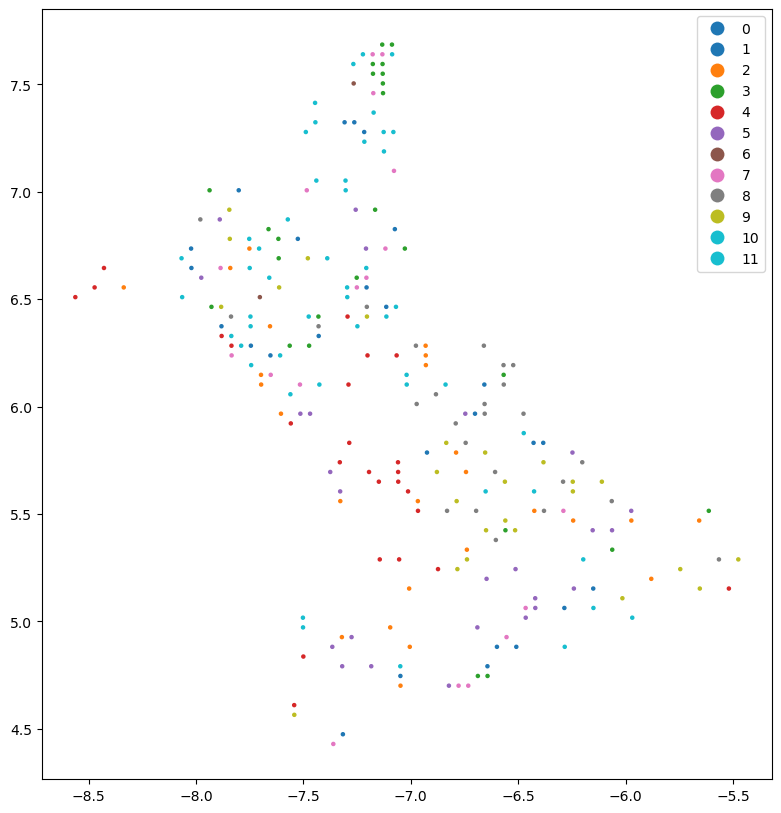

In [17]:
nr_of_samples_per_cluster = 25
subset_df = pd.DataFrame(columns=df.columns)

for cluster in df.Kmeans.unique():
    
    if len(df[df.Kmeans == cluster]) < nr_of_samples_per_cluster:
        
        subset_df = pd.concat([
            subset_df,
            df[df.Kmeans == cluster].sample(len(df[df.Kmeans == cluster]))
        ])
    else:
        
        subset_df = pd.concat([
            subset_df,
            df[df.Kmeans == cluster].sample(nr_of_samples_per_cluster)
        ])
    
print(f'{len(subset_df)} samples have been selected in total')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
subset_df = gpd.GeoDataFrame(subset_df, geometry='geometry')
subset_df.plot(column='Kmeans', ax=ax, legend=True, markersize=5)

# 5 Convert to CEO file

In [18]:
out_csv_file = '/home/sepal-user/sbae_point_analysis_CIV/erp_5km/erp_cluster_pts.csv'

subset_df['LON'] = gpd.GeoDataFrame(subset_df).geometry.x
subset_df['LAT'] = gpd.GeoDataFrame(subset_df).geometry.y
subset_df['PLOTID'] = gpd.GeoDataFrame(subset_df).point_id

cols = subset_df.columns.tolist()
cols = [e for e in cols if e not in ('LON', 'LAT', 'PLOTID')]
new_cols = ['LON', 'LAT', 'PLOTID'] + cols
subset_df = subset_df[new_cols]
subset_df.to_csv(out_csv_file, index=False)